In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json, random, string, re
import matplotlib.cm as cm
import nltk
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# nltk.download('stopwords')
# nltk.download('punkt')

files = os.listdir("./data")

json_data = pd.DataFrame(columns=['src_lang', 'text', 'file_name', 'meme_id'])

for index, js in enumerate(files):
    with open(os.path.join('./data', js)) as json_file:
        json_text = json.load(json_file)
        src_lang = json_text['src_lang']
        text = json_text['text']
        file_name = json_text['file_name']
        meme_id = json_text['id']
        json_data.loc[index] = [src_lang, text, file_name, meme_id]

In [139]:
def clean_column(data):
    if data is not None:
        data = data.lower()
        data = re.sub(r"\n", " ", data)
        data = re.sub(r"i'm", "i am", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r" thats ", " that is ", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r" hes ", " he is ", data)
        data = re.sub(r" shes ", " she is ", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"n\'t", " not", data)
        data = re.sub(r" ur ", " you are ", data)
        data = re.sub(r" u ", " you ", data)
        data = re.sub(r"[0-9]+", "", data)
        data = re.sub(r"[^\w\s]", "", data)
        data = re.sub(r" r ", " are ", data)
        data = re.sub(r" o ", " oh ", data)
        data = re.sub(r" aree ", " are ", data)
        return data

json_data['text'] = json_data['text'].apply(clean_column)

In [140]:
stopwords = set(STOPWORDS)
stopwords.add('yoyou')
stopwords.add('rdankmemes')
stopwords.add('meme')
stopwords.add('memes')
stopwords.add('hoyou')
stopwords.add('rf')
stopwords.add('oh')
stopwords.add('one')

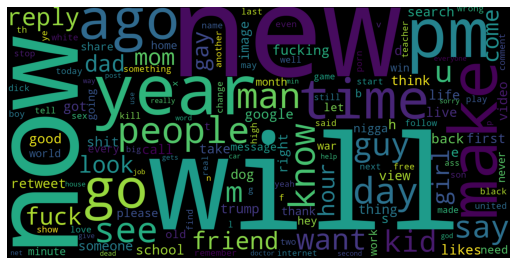

In [141]:
#
# Code taken from here (Kaggle user DFoly1)
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch
#
wordcloud = WordCloud(
    collocations = False,
    width=1600, height=800,
    stopwords=stopwords,
    max_words=150,
    random_state=42
).generate(' '.join(json_data['text']))


print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [142]:
#
# Code taken from here (Kaggle user DFoly1)
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch
#

stemmer = PorterStemmer()

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [143]:
data = json_data['text']

tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=1000) #,tokenizer = tokenize_and_stem, sublinear_tf=True
tf_idf = tf_idf_vectorizer.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_arr = tf_idf_norm.toarray()
print(tf_idf_arr.shape)
pd.DataFrame(tf_idf_arr, columns=tf_idf_vectorizer.get_feature_names()).head()


(3031, 1000)


/home/skuretski/anaconda3/envs/cs410/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,able,abortion,accidentally,account,act,actually,ad,add,address,adult,...,years,yellow,yes,yet,yo,york,young,youre,youtube,ме
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.137595,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Initialization complete
Iteration 0, inertia 8.51440677409207
Iteration 1, inertia 7.386231346280735
Iteration 2, inertia 7.2599891759363855
Iteration 3, inertia 7.259259618512393
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12.253670835508519
Iteration 1, inertia 7.767605360959231
Iteration 2, inertia 7.306140904305293
Iteration 3, inertia 7.262244321982451
Iteration 4, inertia 7.259449344982759
Iteration 5, inertia 7.2592596185123925
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9.386814403803097
Iteration 1, inertia 7.299952307166433
Iteration 2, inertia 7.2592596185123925
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.728632072648532
Iteration 1, inertia 7.787613179871855
Iteration 2, inertia 7.306140904305293
Iteration 3, inertia 7.262244321982451
Iteration 4, inertia 7.259449344982759
Iteration 5, inertia 7.259259618512394
Converged at iteratio

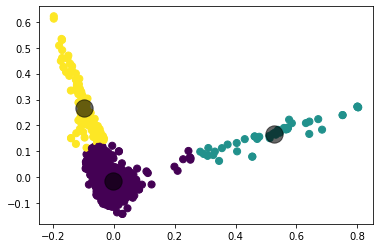

In [144]:
num_clusters = 3

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_arr)

kmeans = KMeans(n_clusters= num_clusters, n_init=20, max_iter=600, algorithm = 'full', verbose=1)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

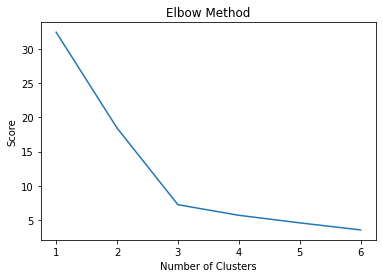

In [145]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.8830004875471427
For n_clusters = 3 The average silhouette_score is : 0.8334547791702538
For n_clusters = 4 The average silhouette_score is : 0.6199154267607595
For n_clusters = 5 The average silhouette_score is : 0.624289473901399
For n_clusters = 6 The average silhouette_score is : 0.4099114606899785


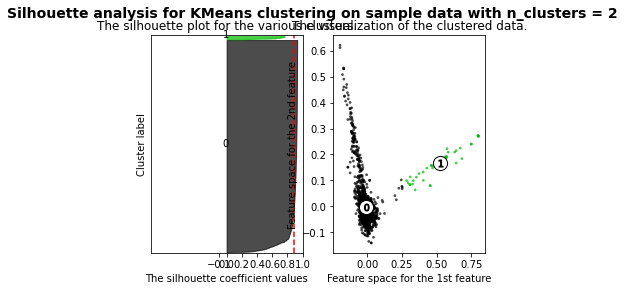

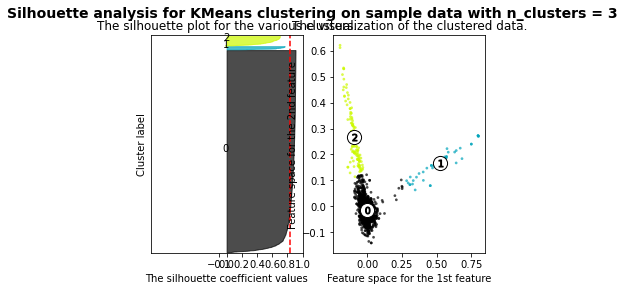

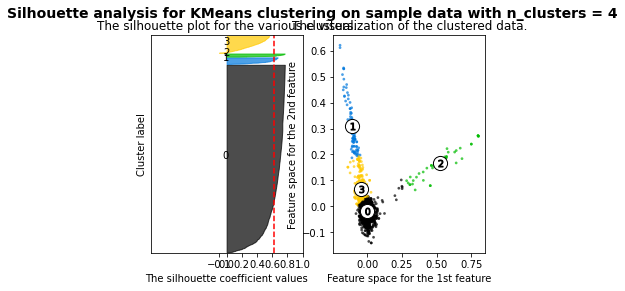

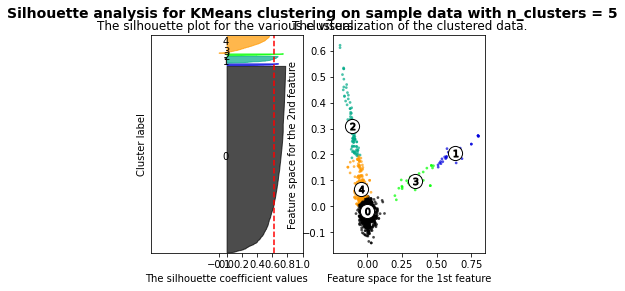

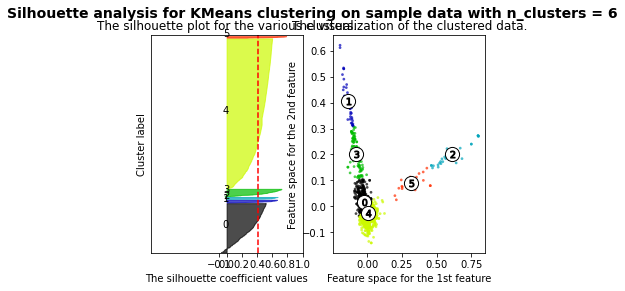

In [151]:
#
# Code for silhouette analysis from here: 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
#

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from [-1, 1] 
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(Y_sklearn) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y_sklearn)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Y_sklearn, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Y_sklearn, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
    

In [147]:
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch

def get_top_features_cluster(tf_idf_arr, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_arr[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_arr, prediction, 20)

<AxesSubplot:xlabel='score', ylabel='features'>

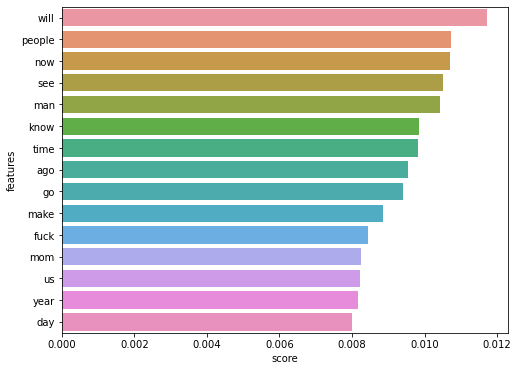

In [148]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

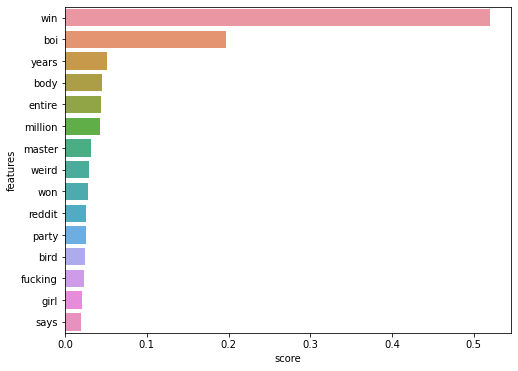

In [149]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

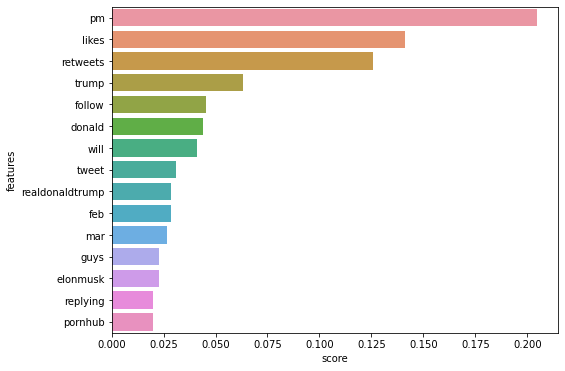

In [150]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])